# PSG for Lung
- convert each feature into a PSG
- Apply SNF
- Implement spectral clustering
- run survival analysis for different options
- content

    - [Function](#Functions)
    - [Reading the dataset (Lung)](#Reading-the-dataset-(Lung))
    - [Direct implementation](#Direct-Implementation)
    - [SNF + Spectral clustering Analysis](#SNF-+-Spectral-clustering-Analysis)
    - [Correlating with Cancer types](#Correlating-with-Cancer-types)
    - [Cancer type-based analysis](#Cancer-type-based-analysis)
    
        - [NSCLC survival analysis](#NSCLC-survival-analysis)
        - [NSCLC_surgery survival analysis](#NSCLC_surgery-survival-analysis)
        - [NSCLC survival analysis](#SCLC-survival-analysis)
    - [Correlating with clusters](#Correlating-with-clusters)

In [1]:
from information import *
from preprocessing import *
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from snfpy.snf import snf
import snf
from sklearn.cluster import spectral_clustering
import functions as ff
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

distance = ['euclidean','minkowski','cityblock','seuclidean','sqeuclidean','cosine','correlation','hamming','jensenshannon','chebyshev','canberra','braycurtis','mahalanobis','yule','matching','dice','kulczynski1','rogerstanimoto','russellrao','sokalmichener']
no_scale = ['vha_id', 'center_name', 'cancer_type']
Prostate_QMs = ['QualityMeasure1','QualityMeasure10','QualityMeasure11','QualityMeasure12','QualityMeasure13','QualityMeasure14','QualityMeasure15','QualityMeasure15_color','QualityMeasure16','QualityMeasure17A','QualityMeasure17B','QualityMeasure18','QualityMeasure19','QualityMeasure2','QualityMeasure24','QualityMeasure3','QualityMeasure4','QualityMeasure5','QualityMeasure6','QualityMeasure7','QualityMeasure8','QualityMeasure9']
Lung_QMs = ['QualityMeasure1','QualityMeasure10','QualityMeasure11','QualityMeasure12','QualityMeasure13','QualityMeasure14','QualityMeasure15','QualityMeasure15Chemo','QualityMeasure15RT','QualityMeasure15Surgery','QualityMeasure16','QualityMeasure17','QualityMeasure18','QualityMeasure19','QualityMeasure19_color','QualityMeasure2','QualityMeasure20','QualityMeasure21A','QualityMeasure21B','QualityMeasure22','QualityMeasure23','QualityMeasure24','QualityMeasure27','QualityMeasure3','QualityMeasure4','QualityMeasure5','QualityMeasure6','QualityMeasure7','QualityMeasure8A','QualityMeasure8B','QualityMeasure9']
dist = distance[0]

uncorrelated = ['Lung_Ipsi_Already_Subtracted_V5Gy',
                 'LungEsophagitisWithGrade',
                 'LU_DVH_25',
                 'LungPneumonitisTotal',
                 'Lung_Contra_Already_Subtracted_V20Gy',
                 'LU_DVH_24',
                 'LU_DVH_28',
                 'Lung_Ipsi_Already_Subtracted_V20Gy',
                 'LU_DVH_23',
                 'Lung_Contra_Already_Subtracted_DMean',
                 'Lung_Ipsi_Already_Subtracted_DMean',
                 'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_V20Gy']

def extract_features(df):
    return [i for i in df if i not in no_scale]

def exclude_QM(df, t):
    if t=='Lung':
        return [i for i in df if i not in Lung_QMs]
    else:
        return [i for i in df if i not in Prostate_QMs]
    
    

### Functions

In [2]:
def scaling(df):
    features_to_scale = extract_features(df)
    scaler = StandardScaler()
    scaler.fit(df[features_to_scale])
    scaled_features = scaler.transform(df[features_to_scale])
    df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)
    df_scaled[no_scale] = df[no_scale]
    return df_scaled

#Dropping columns with missed values of more than 80%

def dropping_cols(df, p=80):
    #1- count the number of NaN values in each column
    #2- calculate the percentage of NaN values in each column
    #3- get the list of columns to drop
    #4- drop the columns with more than 80% NaN values
    nan_counts = df.isna().sum()    
    nan_percentages = nan_counts / len(df) * 100 
    cols_to_drop = nan_percentages[nan_percentages > p].index.tolist()
    df = df.drop(cols_to_drop, axis=1)
    return df    


In [3]:
def histo(data, disease):
    T = data['Days']
    E = data['state']

    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Days-cluster for {disease} Patients')
    plt.hist(T, bins = 30)
    plt.show()

    kmf = KaplanMeierFitter()
    kmf.fit(durations = T, event_observed = E)
    kmf.plot()

    kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

In [4]:
def SNF(DB, dist):
    affinity_networks = snf.make_affinity(DB, metric=dist, K=20, mu=0.5)
    fused_network = snf.snf(affinity_networks, K=20)
    best, second = snf.get_n_clusters(fused_network)
    print(best, second)
    return fused_network, best, second


In [5]:
def groups_details(groups, labels):        
    for i in range(len(groups)):
        print(f'Number of patients in cluser {i} = {len(groups[i])}')


    Ts = [groups[i]['Days'] for i in range(len(groups))]
    Es = [groups[i]['state'] for i in range(len(groups))]

    kmf = KaplanMeierFitter()
    for i in range(len(groups)):
        kmf.fit(durations = Ts[i], event_observed = Es[i], label=labels[i])
        kmf.plot()

    #kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

    import itertools

    # Generate all combinations of length 2 from a list of integers
    numbers = [i for i in range(len(groups))]
    combinations = itertools.combinations(numbers, 2)

    # Perform the log-rank test
    for i, j in combinations:
        results = logrank_test(groups[i]['Days'], groups[j]['Days'], event_observed_A=groups[i]['state'], event_observed_B=groups[j]['state'])
        print(f'P-value ({i},{j}) = ', results.p_value)

In [6]:
def data_impute(df):
#     from sklearn.impute import KNNImputer
#     imputer = KNNImputer(n_neighbors=10)
#     return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df.fillna(df.mode().iloc[0])

In [7]:
from sklearn.decomposition import PCA
def PCA_model(X, n = 2):
#     print("PCA model")
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

### Reading the dataset (Lung)
- reading numerical dataset

In [8]:
# Preprocessing numerical dataset
n_lung = pd.read_csv('data/Lung/numerical.csv', index_col=0)
n_lung = data_impute(n_lung)
scaled_lung = scaling(n_lung)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung = dropping_cols(scaled_lung)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung.dropna(thresh=len(scaled_lung.columns) * 0.2)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung = scaled_lung.drop_duplicates()
print('scaled lung shape is ', scaled_lung.shape)

# scaled_lung = remove_correlated(scaled_lung)
# print('scaled lung shape is ', scaled_lung.shape)


scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)


- reading and processing categorical dataset

In [9]:
# Preprocessing categorical dataset
c_lung = pd.read_csv('data/Lung/categorical.csv', index_col=0)

Lung_patients = list(c_lung['vha_id'])
Lung_cancer_type = list(c_lung['cancer_type'])

c_lung = c_lung[exclude_QM(c_lung, 'Lung')]
c_lung = c_lung[extract_features(c_lung)]

print(c_lung.shape)

# Convert categorical data to numerical data using one-hot encoding
c_lung = data_impute(c_lung)
onehot_encoder = OneHotEncoder()
c_lung = pd.DataFrame(onehot_encoder.fit_transform(c_lung).toarray())
print(c_lung.shape)

print(f'lung cancer types = {set(Lung_cancer_type)}')
scaled_lung = scaled_lung[extract_features(scaled_lung)]

All_in_one = pd.concat([scaled_lung, c_lung], axis=1)
print(All_in_one.shape)

(773, 26)
(773, 78)
lung cancer types = {'NSCLC', 'SCLC', 'NSCLC Surgery'}
(773, 100)


In [21]:
# n_lung = n_lung[uncorrelated]
# scaled_lung = scaled_lung[uncorrelated]
All_in_one = All_in_one[uncorrelated]
list(All_in_one.keys())

['Lung_Ipsi_Already_Subtracted_V5Gy',
 'LungEsophagitisWithGrade',
 'LU_DVH_25',
 'LungPneumonitisTotal',
 'Lung_Contra_Already_Subtracted_V20Gy',
 'LU_DVH_24',
 'LU_DVH_28',
 'Lung_Ipsi_Already_Subtracted_V20Gy',
 'LU_DVH_23',
 'Lung_Contra_Already_Subtracted_DMean',
 'Lung_Ipsi_Already_Subtracted_DMean',
 'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_V20Gy']

# Direct Implementation
## Analysis of the original dataset 
Herein, we used the processed data to do the following:
- PCA dimension reduction to the best 15 features
- implementing the k-means clustering
- survival analysis 
    - cancer types
    - clusters 

In [11]:
from sklearn.cluster import KMeans

print(All_in_one.shape)
newAll = PCA_model(All_in_one, 2)
print(newAll.shape)

kmeans = KMeans(n_clusters=3)
kmeans.fit(newAll)
labels = kmeans.predict(newAll)

lung_All0     = {'vha_id': Lung_patients    , 'cluster': list(labels), 'cancer_type': Lung_cancer_type }
df_lung0 = pd.DataFrame(lung_All0)

survival = pd.read_csv('data/survival.csv')
Lung_survival0 = pd.merge(df_lung0, survival, on='vha_id')

(773, 12)
(773, 2)


checking the statistics...

histo(Lung_survival0, 'Lung')

Number of patients in cluser 0 = 547
Number of patients in cluser 1 = 65
Number of patients in cluser 2 = 161
716.0
     SCLC_lower_0.95  SCLC_upper_0.95
0.5            590.0            970.0
P-value (0,1) =  0.0007351651191957134
P-value (0,2) =  0.8610346077055308
P-value (1,2) =  0.0008006640525357157


,vha_id,cluster,cancer_type,state,firstVisit,lastVisit,Days
0,506-NSCLC-01,0,NSCLC,0,11/18/2009,5/5/2010,168
1,506-NSCLC-02,2,NSCLC,0,11/10/2009,5/9/2010,180
2,506-NSCLC-03,2,NSCLC,0,12/9/2009,8/28/2010,262
3,506-NSCLC-04,2,NSCLC,0,11/18/2009,11/21/2010,368
4,506-NSCLC-05,2,NSCLC,1,12/17/2009,1/15/2011,394


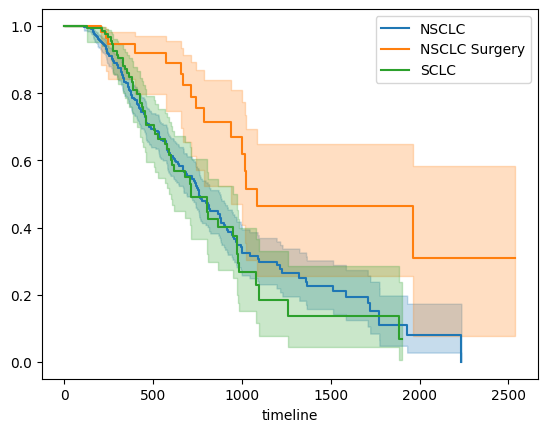

In [12]:
groups0 = dict(tuple(Lung_survival0.groupby('cancer_type')))
groups0 = [groups0[i] for i in groups0]
groups_details(groups0, ['NSCLC', 'NSCLC Surgery', 'SCLC'])
groups0[0].head()

Number of patients in cluser 0 = 240
Number of patients in cluser 1 = 84
Number of patients in cluser 2 = 449
747.0
     2_lower_0.95  2_upper_0.95
0.5         688.0         815.0
P-value (0,1) =  0.66001800887048
P-value (0,2) =  0.14065999004869373
P-value (1,2) =  0.4493746950526819


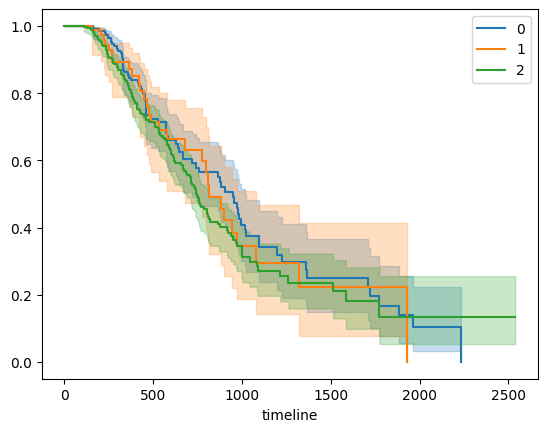

In [13]:
groups = dict(tuple(Lung_survival0.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups, [0,1,2,3])


# SNF + Spectral clustering Analysis
- All Features to PSG
- SNF
- Spectral clustering
- survival analysis 
    - cancer types
    - clusters 

In [14]:
#                                     1- Calculate the similarity matrix
lung_db = []
for d in All_in_one:
    distances = pdist(All_in_one[d].to_numpy().reshape(-1, 1), metric='euclidean')
    similarity_matrix = 1 / (1 + squareform(distances))
    lung_db.append(similarity_matrix)

    
#                                     2- Fusing to SNF
fused_network, best, second = SNF(lung_db, dist)

#                                     3-  Clustering
lung_labels = spectral_clustering(fused_network, n_clusters= 4)


lung_All     = {'vha_id': Lung_patients    , 'cluster': list(lung_labels), 'cancer_type': Lung_cancer_type }
df_lung = pd.DataFrame(lung_All)

survival0 = pd.read_csv('data/survival.csv')
Lung_survival = pd.merge(df_lung, survival0, on='vha_id')
print(Lung_survival.head())

2 3
         vha_id  cluster cancer_type  state  firstVisit   lastVisit  Days
0  506-NSCLC-01        0       NSCLC      0  11/18/2009    5/5/2010   168
1  506-NSCLC-02        1       NSCLC      0  11/10/2009    5/9/2010   180
2  506-NSCLC-03        1       NSCLC      0   12/9/2009   8/28/2010   262
3  506-NSCLC-04        1       NSCLC      0  11/18/2009  11/21/2010   368
4  506-NSCLC-05        1       NSCLC      1  12/17/2009   1/15/2011   394


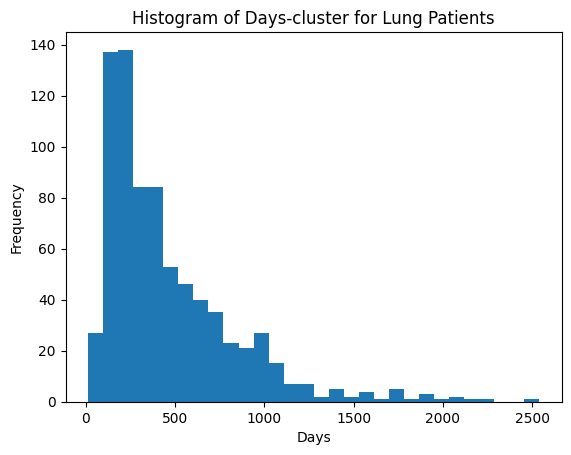

795.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   738.0                   885.0


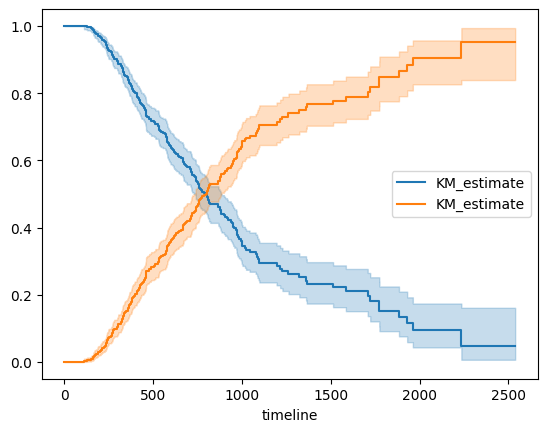

In [15]:
histo(Lung_survival, 'Lung')


# Correlating with Cancer types

Number of patients in cluser 0 = 547
Number of patients in cluser 1 = 65
Number of patients in cluser 2 = 161
716.0
     SCLC_lower_0.95  SCLC_upper_0.95
0.5            590.0            970.0
P-value (0,1) =  0.0007351651191957134
P-value (0,2) =  0.8610346077055308
P-value (1,2) =  0.0008006640525357157


,vha_id,cluster,cancer_type,state,firstVisit,lastVisit,Days
0,506-NSCLC-01,0,NSCLC,0,11/18/2009,5/5/2010,168
1,506-NSCLC-02,1,NSCLC,0,11/10/2009,5/9/2010,180
2,506-NSCLC-03,1,NSCLC,0,12/9/2009,8/28/2010,262
3,506-NSCLC-04,1,NSCLC,0,11/18/2009,11/21/2010,368
4,506-NSCLC-05,1,NSCLC,1,12/17/2009,1/15/2011,394


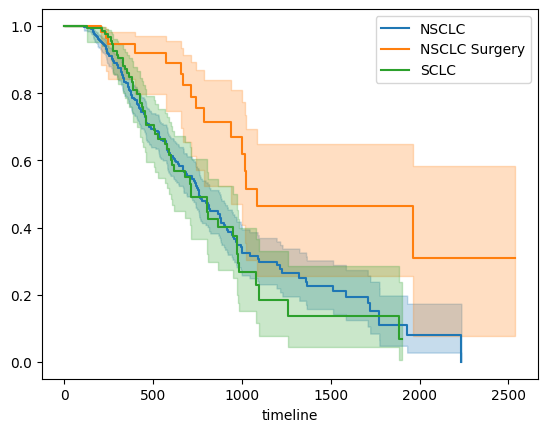

In [16]:
groups = dict(tuple(Lung_survival.groupby('cancer_type')))
groups = [groups[i] for i in groups]
groups_details(groups, ['NSCLC', 'NSCLC Surgery', 'SCLC'])
groups[0].head()

# Cancer type-based analysis
- run PSG, SNF
- divide the SNF into three sub-networks
- run clustering on each
- report survival analysis for each

In [17]:
import networkx as nx

G = nx.Graph()
for i, node in enumerate(Lung_patients):
    G.add_node(i, feature=Lung_cancer_type[i])

for i in range(len(Lung_patients)):
    for j in range(i+1, len(Lung_patients)):
        similarity = fused_network[i][j]
        G.add_edge(i, j, weight=similarity)
        
lung_NSCLC         = [Lung_patients[i] for i in range(len(Lung_patients)) if Lung_cancer_type[i]=='NSCLC']
lung_NSCLC_Surgery = [Lung_patients[i] for i in range(len(Lung_patients)) if Lung_cancer_type[i]=='NSCLC Surgery']
lung_SCLC          = [Lung_patients[i] for i in range(len(Lung_patients)) if Lung_cancer_type[i]=='SCLC']


NSCLC_edges         = [(u,v) for u,v in G.edges() if u in lung_NSCLC and v in lung_NSCLC]
NSCLC_Surgery_edges = [(u,v) for u,v in G.edges() if u in lung_NSCLC and v in lung_NSCLC_Surgery]
SCLC_edges          = [(u,v) for u,v in G.edges() if u in lung_NSCLC and v in lung_SCLC]

G1 = nx.Graph()
G1.add_nodes_from(lung_NSCLC)
G1.add_edges_from(NSCLC_edges)

G2 = nx.Graph()
G2.add_nodes_from(lung_NSCLC_Surgery)
G2.add_edges_from(NSCLC_Surgery_edges)

G3 = nx.Graph()
G3.add_nodes_from(lung_SCLC)
G3.add_edges_from(SCLC_edges)

NSCLC_sim         = nx.to_numpy_array(G1)
NSCLC_Surgery_sim = nx.to_numpy_array(G2)
SCLC_sim          = nx.to_numpy_array(G3)

#                                     3-  Clustering
nc = 4
NSCLC_labels         = spectral_clustering(NSCLC_sim, n_clusters= nc)
NSCLC_Surgery_labels = spectral_clustering(NSCLC_Surgery_sim, n_clusters= nc)
SCLC_labels          = spectral_clustering(SCLC_sim, n_clusters= nc)

D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


## NSCLC survival analysis

Number of patients in cluser 0 = 69
Number of patients in cluser 1 = 241
Number of patients in cluser 2 = 112
Number of patients in cluser 3 = 125
690.0
     3_lower_0.95  3_upper_0.95
0.5         579.0         920.0
P-value (0,1) =  0.8349546328078953
P-value (0,2) =  0.32774786113937604
P-value (0,3) =  0.5300262346175766
P-value (1,2) =  0.23037973407700113
P-value (1,3) =  0.4249751873618942
P-value (2,3) =  0.7807415920085732


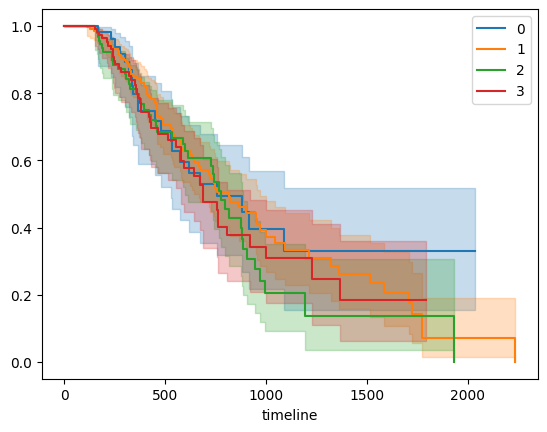

In [18]:
survival0 = pd.read_csv('data/survival.csv')
lung_All = {}
lung_All     = {'vha_id': lung_NSCLC    , 'cluster': list(NSCLC_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival0, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups,[i for i in range(nc)])


## NSCLC_surgery survival analysis

Number of patients in cluser 0 = 29
Number of patients in cluser 1 = 8
Number of patients in cluser 2 = 10
Number of patients in cluser 3 = 18
1003.0
     3_lower_0.95  3_upper_0.95
0.5         655.0           inf
P-value (0,1) =  0.07794156362315079
P-value (0,2) =  0.44899295814668283
P-value (0,3) =  0.08558989640464636
P-value (1,2) =  0.8646131884981826
P-value (1,3) =  0.7344477682065146
P-value (2,3) =  0.7192107680709736


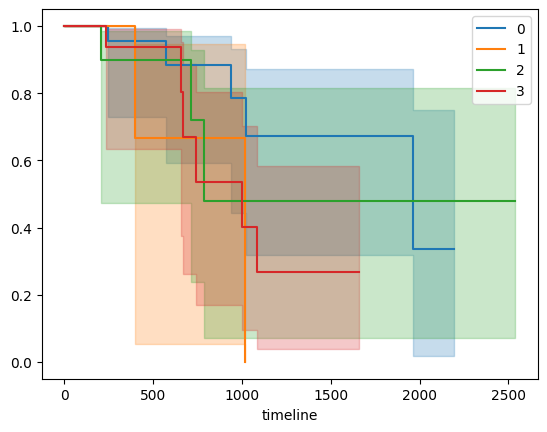

In [19]:
lung_All = {}
lung_All     = {'vha_id': lung_NSCLC_Surgery    , 'cluster': list(NSCLC_Surgery_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival0, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups, [i for i in range(nc)])


## SCLC survival analysis

Number of patients in cluser 0 = 17
Number of patients in cluser 1 = 66
Number of patients in cluser 2 = 41
Number of patients in cluser 3 = 37
806.0
     3_lower_0.95  3_upper_0.95
0.5         445.0        1884.0
P-value (0,1) =  0.8803045040238386
P-value (0,2) =  0.062230954458062065
P-value (0,3) =  0.16578940217181737
P-value (1,2) =  0.08909951165672626
P-value (1,3) =  0.26405521746963395
P-value (2,3) =  0.4806147599130154


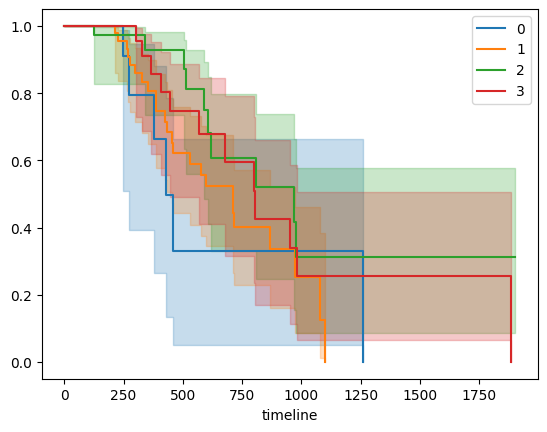

In [20]:
lung_All = {}
lung_All     = {'vha_id': lung_SCLC    , 'cluster': list(SCLC_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival0, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups, [i for i in range(nc)])
